In [4]:
import os
import glob
import numpy as np
import pandas as pd
import astropy.io.fits as pf
import matplotlib.pyplot as plt

In [5]:
# Load TLEs for all passages
with open('../test_data/3leComplete.txt') as f:
    all_tles = f.readlines()
    f.close()   

# Split TLE list into individual lists for each TLE
all_tles = [i.strip() for i in all_tles]
tles = [all_tles[x:x+3] for x in range(0, len(all_tles), 3)]

# Reduce TLEs to Starlink only
starlink_tles = []
for tle in tles:
    if "STARLINK" in tle[0]:
        starlink_tles.append(tle)

# Obtain satellite passages
passed_sats = pd.read_pickle('../test_data/passed_satellites_20221023LSC.p') #passages = passages_20221023LSC.p
keys = list(passed_sats)

# Find any Starlink TLEs in the passages
idx = []
starlinks = np.asarray(starlink_tles).flatten()
for key in keys:
    mascara_tle1 = passed_sats[key]['TLE line1'].strip()
    i = np.where(starlinks == mascara_tle1)[0] #this is not going to be fast for big lists...
    if i.size > 0:
        idx.append(i[0] - 1) #appending the name of the starlink sat
        
# Now have indices for the flattened Starlink TLE list --> divide by 3 to get indices for the original list
orig_idx = [int(x/3) for x in idx]
slk_mas_tles = res_list = [starlink_tles[i] for i in orig_idx]

# Remove 0 labeling of first line of TLE because that's the proper format
for tle in slk_mas_tles:
    tle[0] = tle[0][2:]

print(f'Number of satellites recorded for this day: {len(all_tles)}')
print(f'Number of them that were Starlinks: {len(starlink_tles)}')
print(f'Number of Starlinks that passed MASCARA: {len(slk_mas_tles)}')

Number of satellites recorded for this day: 72222
Number of them that were Starlinks: 3179
Number of Starlinks that passed MASCARA: 931


In [6]:
from skyfield.api import load, wgs84, EarthSatellite, N, S, E, W

# Load the DE421 planetary ephemeris to get positions of Sun and Earth
eph = load('de421.bsp')
sun = eph['sun']
earth = eph['earth']

# Location of MASCARA
mascara = wgs84.latlon(latitude_degrees=29.26111*S, longitude_degrees=70.73139*W, elevation_m=2400)

# Set the observer to be MASCARA at ESO's La Silla Observatory
observer = earth + mascara

# Time range of observation
ts = load.timescale()
t0 = ts.utc(2022, 10, 23)
t1 = ts.utc(2022, 10, 24)

# Convert our TLEs to Skyfield EarthSatellites
sats = []
for tle in slk_mas_tles:
    sats.append(EarthSatellite(tle[1], tle[2], tle[0]))

# Specify our time range
n = 1
day = 24
timerange = ts.utc(2022, 10, day, 0, range(0, 24*60, n))

# We now begin to create list of timeranges for which a satellite is sunlit
sat = sats[0]

# Check when satellite is sunlit 
sunlit = sat.at(timerange).is_sunlit(eph)

# Obtain the indices of the first and last TRUE element for each sequence of TRUE elements 
x = 0
idx = []
for i, n in enumerate(sunlit):
    if n and x==0:
        idx.append(i)
        x=1
    if not n and x==1:
        idx.append(i-1)
        x=0
    if n and i==len(sunlit)-1:
        idx.append(i)

# List of all times for the specified timerange         
all_times = []
for ti in timerange:
    all_times.append(ti.utc_strftime('%Y-%m-%d %H:%M'))

# Obtain times corresponding to the inidces we found 
sunlit_ = [all_times[i] for i in idx]

# Now split into separate list --> now have the start and end time for each sunlit period
sunlit_chunks = [sunlit_[i:i + 2] for i in range(0, len(sunlit_), 2)]

In [7]:
starlink_times = {}

n = 1
timerange = ts.utc(2022, 10, day, 0, range(0, 24*60, n))

for sat in sats:
    x = 0
    idx = []
    sunlit = sat.at(timerange).is_sunlit(eph)
    for i, n in enumerate(sunlit):
        if n and x==0:
            idx.append(i)
            x=1
        if not n and x==1:
            idx.append(i-1)
            x=0
        if n and i==len(sunlit)-1:
            idx.append(i)

    sunlit_ = [timerange.tt[i] for i in idx]
    values = [sunlit_[i:i + 2] for i in range(0, len(sunlit_), 2)]
    
    starlink_times[sat.name] = values

In [8]:
sat = list(starlink_times)[0]
starlink_times[sat][0][0]

2459876.500800741

In [9]:
# Maybe take average time ? For each row

# Some satellites have 16 time elements, some have 15..

def avg_time(N):
    from scipy import stats as st
    vals = []
    cur1 = []
    cur2 = []
    keys = list(starlink_times)
        
    for j in range(N):
        for sat in keys:
            if len(starlink_times[sat]) != N:
                continue
            else:
                cur1.append(starlink_times[sat][j][0])
                cur2.append(starlink_times[sat][j][1])
        vals.append([np.mean(cur1), np.mean(cur2)])
        #vals.append([st.mode(cur1, keepdims=False)[0], st.mode(cur2, keepdims=False)[0]])
        cur1 = []
        cur2 = []
    return vals

In [10]:
avg_times_16 = avg_time(N=16)
avg_times_15 = avg_time(N=15)

In [11]:
x=0
y=0
keys = list(starlink_times)
for sat in keys:
    if len(starlink_times[sat]) == 16:
        x+=1
    if len(starlink_times[sat]) == 15:
        y+=1        
print(x, y)

655 218


In [12]:
for i in avg_times_16:
    print(ts.tt_jd(i[0]).utc_strftime('%H:%M'), ts.tt_jd(i[1]).utc_strftime('%H:%M'))

00:02 00:39
01:11 02:14
02:46 03:49
04:21 05:24
05:56 06:59
07:31 08:34
09:06 10:10
10:42 11:45
12:17 13:20
13:52 14:55
15:27 16:30
17:02 18:06
18:38 19:41
20:13 21:16
21:48 22:51
23:23 23:59


In [13]:
for i in avg_times_16:
    print(ts.tt_jd(i[0]).tt_strftime('%H:%M'), ts.tt_jd(i[1]).tt_strftime('%H:%M'))

00:03 00:40
01:12 02:15
02:47 03:50
04:22 05:25
05:57 07:00
07:32 08:36
09:08 10:11
10:43 11:46
12:18 13:21
13:53 14:56
15:28 16:32
17:03 18:07
18:39 19:42
20:14 21:17
21:49 22:52
23:24 00:00


In [14]:
# Elevation --> leave this for now

t = ts.utc(2022, 10, 23)
sat = sats[0]

geocentric = sat.at(t)
print(geocentric.position.km)

lat, lon = wgs84.latlon_of(geocentric)
print('Latitude:', lat)
print('Longitude:', lon)

difference = sat - mascara
topocentric = difference.at(t)
print(topocentric.position.km)

alt, az, distance = topocentric.altaz()

if alt.degrees > 0:
    print(f'{sat.name} is above the horizon')

print('Altitude:', alt)
print('Azimuth:', az)
print('Distance: {:.1f} km'.format(distance.km))

[-6589.3104352   -868.0187944  -1960.50182351]
Latitude: -16deg 39' 23.8"
Longitude: 156deg 24' 18.2"
[-10873.20276343   2685.12925782   1149.14461799]
Altitude: -56deg 09' 49.6"
Azimuth: 230deg 56' 53.5"
Distance: 11258.6 km


### Check when satellite is above horizon:


In [15]:
ts = load.timescale()

mascara = wgs84.latlon(latitude_degrees=29.26111*S, longitude_degrees=70.73139*W, elevation_m=2400)
t0 = ts.utc(2022, 10, 24)
t1 = ts.utc(2022, 10, 25)

sat = sats[100]
t, events = sat.find_events(mascara, t0, t1, altitude_degrees=30)
for ti, event in zip(t, events):
    name = ('rise above 30°', 'culminate', 'set below 30°')[event]
    print(ti.utc_strftime('%Y %b %d %H:%M:%S'), name)

2022 Oct 24 01:12:48 rise above 30°
2022 Oct 24 01:14:00 culminate
2022 Oct 24 01:15:13 set below 30°
2022 Oct 24 16:00:10 rise above 30°
2022 Oct 24 16:01:26 culminate
2022 Oct 24 16:02:44 set below 30°


In [16]:
from skyfield.almanac import find_discrete, risings_and_settings
from pytz import timezone

eph = load('de421.bsp')

f = risings_and_settings(eph, sun, mascara)
tz = timezone('Chile/Continental')

for t, updown in zip(*find_discrete(t0, t1, f)):
    print(t.astimezone(tz).strftime('%a %d %H:%M'),
          'rises' if updown else 'sets')

Mon 24 06:57 rises
Mon 24 19:57 sets


In [17]:
import datetime as dt
from pytz import timezone
from skyfield import almanac
from skyfield.api import N, W, wgs84, load

# Figure out local midnight.
zone = timezone('Chile/Continental')
now = zone.localize(dt.datetime.now())
midnight = now.replace(hour=0, minute=0, second=0, microsecond=0)
next_midnight = midnight + dt.timedelta(days=1)

ts = load.timescale()
# t0 = ts.from_datetime(midnight)
# t1 = ts.from_datetime(next_midnight)
t0 = ts.utc(2022, 10, 24)
t1 = ts.utc(2022, 10, 25)
eph = load('de421.bsp')

f = almanac.dark_twilight_day(eph, mascara)
times, events = almanac.find_discrete(t0, t1, f)

previous_e = f(t0).item()
for t, e in zip(times, events):
    tstr = str(t.astimezone(zone))[:16]
    if previous_e < e:
        print(tstr, ' ', almanac.TWILIGHTS[e], 'starts')
    else:
        print(tstr, ' ', almanac.TWILIGHTS[previous_e], 'ends')
    previous_e = e

2022-10-23 21:21   Astronomical twilight ends
2022-10-24 05:32   Astronomical twilight starts
2022-10-24 06:02   Nautical twilight starts
2022-10-24 06:31   Civil twilight starts
2022-10-24 06:56   Day starts
2022-10-24 19:58   Day ends
2022-10-24 20:22   Civil twilight ends
2022-10-24 20:52   Nautical twilight ends


In [18]:
t, events = sat.find_events(mascara, t0, t1, altitude_degrees=18)
below = t[2::3]
above = t[1::3]
periods = list(zip(below, above))
periods

[(<Time tt=2459876.5535617857>, <Time tt=2459876.552186735>),
 (<Time tt=2459877.1699002087>, <Time tt=2459877.1684666267>)]

In [19]:
img = 'diff_48506263LSC.fits.gz'
_, header = pf.getdata(f'../test_data/diff_images/{img}', header=True)
jd0 = header[7]
jd1 = header[8]
midJD = header[12]

In [20]:
srt = ts.tt_jd(2459876.517563686).utc_strftime()
fin = ts.tt_jd(2459879.517563686).utc_strftime()

beg = pd.to_datetime(srt)
end = pd.to_datetime(fin)
rng = pd.date_range(beg, end, freq='0.05H').to_pydatetime().tolist() #every 3 minutes

times = ts.from_datetimes(rng)
sunlit = sat.at(times).is_sunlit(eph)

In [21]:
# Check if midJD is within any of the ranges
idx = []
for timerange in avg_times_16:
    if ts.tt_jd(midJD).tt >= timerange[0] and ts.tt_jd(midJD).tt <= timerange[1]:
        idx.append(timerange)
print(idx)

[[2459876.5022383993, 2459876.5275458638]]


In [22]:
diffimg_with_starlink = []
for timerange in avg_times_16:
    if ts.tt_jd(midJD).tt >= timerange[0] and ts.tt_jd(midJD).tt <= timerange[1]:
        diffimg_with_starlink.append(img[-19:-11])

Number of images expected to have Starlink trails visible: 32

['48508923', '48507687', '48506263', '48508093', '48510552', '48506374', '48509667', '48508038', '48507013', '48507007', '48508075', '48507951', '48510677', '48509481', '48507697', '48509572', '48506795', '48509870', '48510791', '48510736', '48510870', '48506731', '48509980', '48506341', '48506377', '48507667', '48507022', '48508889', '48510747', '48508951', '48508711', '48510668']

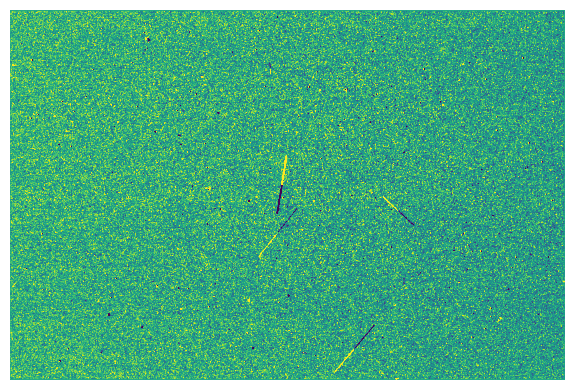

In [23]:
plt.figure(figsize=[6,4])
diff_data, diff_header = pf.getdata('../diff_48506377LSC.fits.gz', header=True) 
plt.imshow(diff_data, vmin=-15, vmax=10)
plt.axis('off')
plt.tight_layout()
# plt.savefig('diff_image_48506263.png', dpi=300, format='png')
plt.show()

In [24]:
# All the Starlink satellite numbers
starlinks_no = []
for sat in starlink_tles:
    starlinks_no.append(sat[1][2:8])
    
for sat in starlinks_no:
    i = np.where(sat == '43910U')[0]
    if i.size > 0:
        print(i)

In [25]:
known = pd.read_pickle('../known_satellites20221023LSC.p')
print(list(known['positive']))
print(known['positive']['25861U'])

['43563U']


KeyError: '25861U'

In [ ]:
def calcSatSunPhase(sat, loc, ephemeris, tEv):
    earth = ephemeris['earth']

    vecObserverSat = (sat - loc).at(tEv)
    vecSunSat = (earth + sat).at(tEv)
    phase = vecObserverSat.separation_from(vecSunSat)

    return phase

python full_code.py -n 3000 -f '20221023LSC' <br>
Number of satellites recorded for this day: 72222 <br>
Number of them that were Starlinks: 3179 <br>
Number of Starlinks that passed MASCARA: 931 <br>
Collecting images from 20221023LSC <br>
Determining timerange <br>
Oldest date: 2022-10-24 00:24:08 UTC <br>
Newest date: 2022-10-24 08:59:06 UTC <br>
Runtime: 3700.03729224205 <br>
Creating EarthSatellites <br>
Finding sunlit times <br>
Checking when each sunlit Starlink is within image <br>
Triple nested For Loop for 3000 images took 0.06397652626037598 <br>
Number of images expected to have Starlink trails visible: 2971 <br>
Elapsed:1:01:44.14,User=2928.225,System=601.843,CPU=95.3%.

In [ ]:
test = '/net/beulakerwijde/data1/breslin/data/subtracted/20221023LSC/diff_48508241LSC.fits.gz'
test[-19:-11]

## Monday 6th March

In [27]:
def sun_position(siteinfo, t=None):
    """ Compute sun position. """

    import datetime
    from astropy.time import Time
    from astropy.coordinates import EarthLocation, get_body, AltAz

    # If no time is given use system time.
    if t is None:
        t = Time(datetime.datetime.utcnow(), scale='utc')
    else:
        t = Time(t, scale='utc', format='jd')
    
    # Location of observatory and Alt-Az coordinate frame.
    loc = EarthLocation.from_geodetic(siteinfo['lon'], siteinfo['lat'], siteinfo['height'])  
    frame = AltAz(obstime=t, location=loc)       
    
    # Coordinates of the sun.
    sun = get_body('sun', t)
    ra, dec = sun.ra.value, sun.dec.value
    sun = sun.transform_to(frame)
    alt = sun.alt.value

    return ra, dec, alt
 
# import datetime as dt
# from astropy.time import Time
# date = Time(dt.datetime(2022, 10, 23))
# ra, dec, alt = sun_position(siteinfo, t=date)

In [28]:
def read_siteinfo(camid):
    confdir = '../fotos-python3/bringfiles'
    confdir = os.path.join(confdir, 'siteinfo.dat') 
    dtype = [('sitename', '|U20'), ('lat', 'float32'), ('lon', 'float32'), ('height', 'float32'), ('ID', '|U2')]
    siteinfo = np.genfromtxt(confdir, dtype=dtype)   
    mask = siteinfo['ID'] == camid[:2]
    siteinfo = siteinfo[mask]
    return siteinfo 

## Alt, Az of Sun

In [29]:
from skyfield.api import load, wgs84

siteinfo = read_siteinfo('LSC')
lat = siteinfo[0][1]
lon = siteinfo[0][2]
ele = siteinfo[0][3]

ts = load.timescale()
t = ts.utc(2022, 10, 23)

# specify a location on Earth by giving its latitude and longitude to a standard “geodetic system” 
# that models the Earth’s shape --> wgs84

# Altitude and azimuth in the sky of a specific geographic location:
eph = load('de421.bsp')
earth = eph['earth']
sun = eph['sun']

mascara = earth + wgs84.latlon(latitude_degrees=lat, longitude_degrees=lon, elevation_m=ele)
astro = mascara.at(t).observe(sun) #astrometric
app = astro.apparent()
alt, az, distance = app.altaz()
print(alt.dstr())
print(az.dstr())

"""The altitude returned from a plain altaz() call is the ideal position that you would observe 
if the Earth had no atmosphere. You can also ask Skyfield to estimate where an object might actually 
appear in the sky after the Earth’s atmosphere has refracted its image higher. 
If you know the weather conditions, you can specify them."""

# alt, az, dist = app.altaz(temperature_C=15.0, pressure_mbar=1005.0)
# alt, az, dist = app.altaz('standard') standard T and P for skyfield simulation of the effects of refraction

-13deg 55' 28.8"
248deg 14' 51.8"


'The altitude returned from a plain altaz() call is the ideal position that you would observe \nif the Earth had no atmosphere. You can also ask Skyfield to estimate where an object might actually \nappear in the sky after the Earth’s atmosphere has refracted its image higher. \nIf you know the weather conditions, you can specify them.'

## Alt, Az of satellite

In [31]:
from skyfield.api import load, wgs84, EarthSatellite

siteinfo = read_siteinfo('LSC')
lat = siteinfo[0][1]
lon = siteinfo[0][2]
ele = siteinfo[0][3]

ts = load.timescale()
t = ts.utc(2022, 10, 23)

eph = load('de421.bsp')
earth = eph['earth']
sun = eph['sun']

satellite = slk_mas_tles[0]
sat = EarthSatellite(satellite[1], satellite[2], satellite[0], ts)

# (x,y,z) position relative to the Earth’s center in the Geocentric Celestial Reference System
geocentric = sat.at(t)
geolat, geolon = wgs84.latlon_of(geocentric)


""" Satellite altitude, azimuth, and distance:
    You might be most interested in whether the satellite is above or below the horizon from the observer, 
    and in which direction to look for it. If you build an object to represent your latitude and longitude, 
    you can use vector subtraction to ask “where will the satellite be relative to my location? """


mascara = wgs84.latlon(latitude_degrees=lat, longitude_degrees=lon, elevation_m=ele)
diff = sat - mascara


""" Every time you call this vector sum’s at() method, it will compute the satellite’s position, then your 
    own position, then subtract them. The RESULT will be the POSITION OF THE SATELLITE RELATIVE TO THE  
    OBSERVER. If you are interested you can access this relative position as plain (x,y,z) coordinates:"""


topocentric = diff.at(t)
print(topocentric.position.km)


""" But the most popular approach is to ask the topocentric position for its altitude and azimuth. 
    The altitude angle runs from 0° at the horizon to 90° directly overhead at the zenith. 
    A negative altitude means the satellite is that many degrees below the horizon. """


alt, az, dist = topocentric.altaz()

if alt.degrees > 0:
    print(f'{satellite[0]} is above the horizon')

print('Altitude:', alt)
print('Azimuth:', az)
print('Distance: {:.1f} km'.format(dist.km))

[-10872.95235678   2685.7294895    1148.7435036 ]
Altitude: -56deg 09' 45.9"
Azimuth: 230deg 57' 16.1"
Distance: 11258.5 km


## Alt, Az of Sun and Satellite + height of Satellite

In [289]:
def altaz_skyfield(satellite):

    from skyfield.api import load, wgs84, EarthSatellite
    
    # La Silla info
    siteinfo = read_siteinfo('LSC')
    lat = siteinfo[0][1]
    lon = siteinfo[0][2]
    ele = siteinfo[0][3]
    
    # Set date of observation
    ts = load.timescale()
    t = ts.utc(2022, 10, 23)
    
    # Load ephemeris
    eph = load('de421.bsp')
    earth = eph['earth']
    sun = eph['sun']
    
    # Find Sun alt and az
    obs = earth + wgs84.latlon(latitude_degrees=lat, longitude_degrees=lon, elevation_m=ele)
    astro = obs.at(t).observe(sun) #astrometric
    app = astro.apparent()
    sun_alt, sun_az, dist = app.altaz()
    
    # Now for Starlink
    sat = EarthSatellite(satellite[1], satellite[2], satellite[0], ts)
    
    # Check whether the sat is above or below the horizon from MASCARA, and in which direction to look for it
    mascara = wgs84.latlon(latitude_degrees=lat, longitude_degrees=lon, elevation_m=ele)
    diff = sat - mascara
    
    # Position of sat relative to MASCARA
    topocentric = diff.at(t)
    alt, az, dist = topocentric.altaz()

    if alt.degrees > 0:
        print(f'{satellite[0]} is above the horizon')
    else:
        print(f'{satellite[0]} is below the horizon')
        
    print('Sun Alt:', sun_alt)
    print('Sun Az:', sun_az)
    print('Sat Alt:', alt)
    print('Sat Az:', az)
    print('Sat Dist: {:.1f} km'.format(dist.km))
    
    # wWhere among the stars the sat will be positioned
    ra, dec, radec_dist = topocentric.radec()
    
    # Satellite elevation
    geocentric = sat.at(t)
    height = wgs84.height_of(geocentric)
    # subpoint = wgs84.subpoint(geocentric) # subpoint.elevation.km # Just another way of doing it!

    print(f'Sat elev above MASCARA: {height.km} km')
    print(f'Sat elev above Earth:   {height.km + ele/1000.} km')
    
    return ra, dec
    

In [290]:
ra, dec = altaz_skyfield(slk_mas_tles[0])

STARLINK-2181 is below the horizon
Sun Alt: -13deg 55' 28.8"
Sun Az: 248deg 14' 51.8"
Sat Alt: -56deg 09' 45.9"
Sat Az: 230deg 57' 16.1"
Sat Dist: 11258.5 km
Sat elev above MASCARA: 552.9677638649673 km
Sat elev above Earth:   555.337163767311 km


## Find camera FOV

In [85]:
data, header = pf.getdata('../diff_48506377LSC.fits.gz', header=True)
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4008                                                  
NAXIS2  =                 2672                                                  
LST0    =    22.03604864331993 / LST of first (subtracted) image                
LST1    =     22.0378264038546 / LST of second image                            
JD0     =    2459876.524655353 / JD of first (subtracted) image                 
JD1     =    2459876.524729224 / JD of second image                             
EXP0    =    6.382925199344754 / Exposure of first (subtracted) image           
EXP1    =    6.381928700022399 / Exposure of second image                       
MIDLST  =     22.0307149022507 / LST to which images are shifted                
MIDJD   =     2459876.524433

In [83]:
def camera_fov():    
    #Check if the Moon is in FoV of camera
    observatory = EarthLocation(lat=siteinfo['lat']*u.deg, lon=siteinfo['lon']*u.deg, height=siteinfo['height']*u.m)        
    gcrs_coords = get_moon(Time(JD, format='jd'), location=observatory)


    moonx_astropy, moony_astropy, moon_mask = self.astro.world2pix(self.midlst,
                                                                   gcrs_coords.ra.value[0],
                                                                   gcrs_coords.dec.value[0],
                                                                   jd=self.midJD, 
                                                                   margin=-moonmargin)


In [136]:
def get_pars():    
    import h5py
    filelist = np.sort(glob.glob('../test_data/diff_images/*.fits.gz'))
    files = [filename for filename in filelist if not any(s in filename for s in ['dark','bias','flat'])]
    lstseq = np.array([np.int64(fff[-19:-11]) for fff in files])

    curlstseq = lstseq[0]
    data, header = pf.getdata(files[0], header=True)
    JD0 = header['JD0']
    lst0 = header['LST0']
    JD1 = header['JD1']   
    lst1 = header['LST1']    
    midlst = header['MIDLST']
    midJD = header['MIDJD']
    nx = header['XSIZE']    
    ny = header['YSIZE']

    fast = h5py.File('../fast_20221023LSC.hdf5','r')
    curastro = np.where((fast['astrometry/lstseq'][()] // 50) == (curlstseq // 50))[0][0]
    order = fast['astrometry/x_wcs2pix'][curastro].shape[0]-1
    astrolst= fast['station/lst'][np.where(fast['station/lstseq'][()] == (fast['astrometry/lstseq'][curastro]))[0][0]]
    
    wcspars = {'crval'  : fast['astrometry/crval'][curastro].copy(),
                'crpix' : fast['astrometry/crpix'][curastro].copy(),
                'cdelt' : [0.02148591731740587,0.02148591731740587],
                'pc'    : fast['astrometry/pc'][curastro].copy(),
                'lst'   : astrolst}

    polpars = {'x_wcs2pix'  : fast['astrometry/x_wcs2pix'][curastro].copy(),
                'y_wcs2pix' : fast['astrometry/y_wcs2pix'][curastro].copy(),
                'x_pix2wcs' : fast['astrometry/x_pix2wcs'][curastro].copy(),
                'y_pix2wcs' : fast['astrometry/y_pix2wcs'][curastro].copy(),
                'nx'    : nx,
                'ny'    : ny,
                'order' : order}
    
    fast.close()
    
    return wcspars, polpars

wcspars, polpars = get_pars()

48506263


In [86]:
import h5py
fast = h5py.File('../fast_20221023LSC.hdf5','r')
keys = list(fast['station'])
for i in range(len(keys)):
    print(i, fast['station'][keys[i]])
fast.close()

0 <HDF5 dataset "ccdtemp": shape (4492,), type "<f4">
1 <HDF5 dataset "darkfile": shape (4492,), type "<u4">
2 <HDF5 dataset "day": shape (4492,), type "|u1">
3 <HDF5 dataset "dwldtime": shape (4492,), type "<f4">
4 <HDF5 dataset "exptime": shape (4492,), type "<f4">
5 <HDF5 dataset "fsec": shape (4492,), type "<f4">
6 <HDF5 dataset "hour": shape (4492,), type "|u1">
7 <HDF5 dataset "immed": shape (4492,), type "<u2">
8 <HDF5 dataset "imnsat": shape (4492,), type "<u4">
9 <HDF5 dataset "imnzero": shape (4492,), type "<u4">
10 <HDF5 dataset "imstd": shape (4492,), type "<f4">
11 <HDF5 dataset "jd": shape (4492,), type "<f8">
12 <HDF5 dataset "lst": shape (4492,), type "<f8">
13 <HDF5 dataset "lstday": shape (4492,), type "<u4">
14 <HDF5 dataset "lstidx": shape (4492,), type "<u4">
15 <HDF5 dataset "lstseq": shape (4492,), type "<u4">
16 <HDF5 dataset "margtime": shape (4492,), type "<f4">
17 <HDF5 dataset "min": shape (4492,), type "|u1">
18 <HDF5 dataset "month": shape (4492,), type "|

In [89]:
fast = h5py.File('../fast_20221023LSC.hdf5','r')
keys = list(fast['station'])
test = fast['station'][keys[11]]
# test[()]
# fast.close()

In [90]:
for i in keys:
    print(i, fast['station'][i][()])

ccdtemp [-5. -5. -5. ... -5. -5. -5.]
darkfile [48505619 48505619 48505619 ... 48505619 48505619 48505619]
day [24 24 24 ... 24 24 24]
dwldtime [1.6269706 1.6269652 1.6269717 ... 1.6269708 1.6269674 1.6269901]
exptime [6.382928  6.382925  6.3829274 ... 6.3829045 6.3829236 6.3829107]
fsec [609464. 992462. 375464. ... 963452. 346462. 729455.]
hour [0 0 0 ... 9 9 9]
immed [1124 1124 1124 ... 2132 2154 2177]
imnsat [0 0 0 ... 4 5 6]
imnzero [0 0 0 ... 0 0 0]
imstd [223.53387 223.04701 223.53165 ... 489.35342 494.69794 499.12814]
jd [2459876.51623391 2459876.51630778 2459876.51638166 ... 2459876.87665467
 2459876.87672855 2459876.87680242]
lst [21.83338056 21.83515848 21.83693638 ...  6.50716135  6.50893926
  6.51071717]
lstday [3593 3593 3593 ... 3593 3593 3593]
lstidx [ 763  764  765 ... 5642 5643 5644]
lstseq [48506263 48506264 48506265 ... 48511142 48511143 48511144]
margtime [0. 0. 0. ... 0. 0. 0.]
min [23 23 23 ...  2  2  2]
month [10 10 10 ... 10 10 10]
moonalt [-37.169956  -37.18927

In [105]:
print(fast['astrometry'].keys())
fast.close()

<KeysViewHDF5 ['crpix', 'crval', 'dec0', 'dec1', 'dec2', 'dec3', 'dec4', 'dr', 'dx', 'dy', 'fstars', 'lstseq', 'pc', 'ra0', 'ra1', 'ra2', 'ra3', 'ra4', 'ustars', 'x_pix2wcs', 'x_wcs2pix', 'y_pix2wcs', 'y_wcs2pix']>


In [68]:
### FUNCTIONS I THINK ARE NEEDED TO TRANSFORM PIXEL COORDS TO LOOK AT FOV

def world2pix(lst, ra, dec, jd=None, nx=4008, ny=2672, margin=50):
    xwcs, ywcs = world2wcs(wcspars, ra, dec, lst, jd) # Compute wcs-only pixel coordinates
    mask = np.isfinite(xwcs) & clip_rectangle(xwcs, ywcs, nx, ny, margin) # Remove coordinates not within the margins
    xwcs, ywcs = xwcs[mask], ywcs[mask]        
    xpix, ypix = wcs2pix(polpars, xwcs, ywcs) # Convert to actual pixel coordinates.
    return xpix, ypix, mask


def clip_rectangle(x, y, nx, ny, margin):
    maskx = (x > margin) & (x < (nx - margin))
    masky = (y > margin) & (y < (ny - margin))
    return maskx & masky


def world2wcs(wcspars, ra, dec, lst=None, jd=None):
    """ Convert world coordinates to WCS-only coordinates. """    
    if jd is not None:
        ra, dec = j2000_to_equinox(ra, dec, jd)
    w = create_wcs(wcspars, lst)
    xwcs, ywcs = w.wcs_world2pix(ra, dec, 0)
    return xwcs, ywcs


def create_wcs(wcspars, lst=None):
    """ Create and astropy WCS instance from a dictionary of parameters. """  
    from astropy import wcs
    
    if lst is not None:
        ra0, dec0 = wcspars['crval']
        ha0 = ra2ha(ra0, wcspars['lst'])
        ra0 = ha2ra(ha0, lst)
        crval = np.array([ra0, dec0])   
    else:
        crval = wcspars['crval']
        
    w = wcs.WCS(naxis=2)
    w.wcs.crpix = wcspars['crpix']
    w.wcs.cdelt = wcspars['cdelt']
    w.wcs.crval = crval
    w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    w.wcs.pc = wcspars['pc']
    return w


def ra2ha(ra, lst):
    """ Convert Right Ascension to Hour Angle. """
    ha = np.mod(lst*15. - ra, 360.)
    return ha

def ha2ra(ha, lst):
    """ Convert Hour Angle to Right Ascension. """    
    ra = np.mod(lst*15. - ha, 360.)
    return ra


def j2000_to_equinox(ra, dec, jd):
    from astropy.time import Time
    from astropy.coordinates import SkyCoord, FK5
    t = Time(jd, scale='utc', format='jd') 
    t.format = 'jyear_str'
    gc = SkyCoord(ra, dec, frame='fk5', unit='deg', equinox='J2000')    
    gc = gc.transform_to(FK5(equinox=t))    
    return gc.ra.value, gc.dec.value


def wcs2pix(polpars, xwcs, ywcs):
    """ Convert WCS-only coordinates to pixel coordinates. """     
    dx, dy = leg2d_eval(xwcs, ywcs, polpars['x_wcs2pix'], polpars['y_wcs2pix'], 
                        polpars['order'], polpars['nx'], polpars['ny'])    
    xpix, ypix = xwcs + dx, ywcs + dy
    return xpix, ypix


def leg2d_eval(x, y, a, b, order=6, nx=4008., ny=2672.):
    """ Evaluate 2-D polynomials. """
    mat, idx1, idx2 = leg2d_mat(x, y, order, nx, ny)
    xres = np.dot(mat, a[idx1, idx2])
    yres = np.dot(mat, b[idx1, idx2])
    return xres, yres  


def leg2d_mat(x, y, order=6, nx=4008., ny=2672.):
    """ Create a matrix for fitting 2-D polynomials of the given order. """ 
    from numpy.polynomial import legendre
    x = np.array(x)
    y = np.array(y)
    mat1 = legendre.legvander(2*(x/nx) - 1, order+1)
    mat2 = legendre.legvander(2*(y/ny) - 1, order+1)
        
    idx1, idx2 = np.indices((order+1, order+1))
    mask = ((idx1 + idx2) <= order)
    idx1, idx2 = idx1[mask], idx2[mask]        
        
    mat = mat1[:,idx1]*mat2[:,idx2]
    return mat, idx1, idx2

In [ ]:
x_apy, y_apy, mask = world2pix(midlst, gcrs_coords.ra.value[0], gcrs_coords.dec.value[0], jd=midJD)

In [95]:
midLST = header[11]
midJD  = header[12]

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import EarthLocation, get_moon

# EarthLocation --> input=geodetic (lat,lon,height) ; output=geocentric (x,y,z) coords (i.e. gcrs / cartesian)
observatory = EarthLocation(lat=siteinfo['lat']*u.deg, lon=siteinfo['lon']*u.deg, height=siteinfo['height']*u.m)
moon_coords = get_moon(Time(midJD, format='jd'), location=observatory)

In [98]:
print(observatory) 
print(mascara)

[(1837837.2875545, -5259159.82817909, -3099953.78920708)] m
WGS84 latitude -29.2571 N longitude -70.7378 E elevation 2369.4 m


A **Barycentric position** measures from the Solar System’s center of mass. This places its (x,y,z) vector in the Barycentric Celestial Reference System (BCRS) — a frame of reference that’s inertial enough to support the observe() method. You’ll usually start a Skyfield script by generating a barycentric position for the center from which you’ll be observing — whether that’s the Earth, or a specific location on the Earth’s surface, or another body like a satellite, planet, or moon.


An **Astrometric position** is returned by the Barycentric.observe() method which, given a target you want to observe, applies the effect of light travel time. For example, on Earth we see the Moon where it was about 1.3 seconds ago, the Sun where it was 8 minutes ago, Jupiter where it was more than half an hour ago, and Neptune where it was about 4 hours ago.


An **Apparent position** is computed by calling the Astrometric.apparent() method. This applies two real-world effects that slightly shift everything in the sky: the aberration of light produced by the observer’s own motion through space, and the gravitational deflection of light that passes close to masses like the Sun and Jupiter — and, for an observer on the Earth’s surface, for deflection produced by the Earth’s own gravity. The result is an “apparent” position telling you where the target will really “appear” in tonight’s sky; it’s the direction you should point your telescope.


When an apparent position is measured from the Earth’s center, it can be described more formally as an (x,y,z) position in **Geocentric Celestial Reference System (GCRS)** coordinates.


GCRS is distinct form **ICRS** mainly in that it is relative to the Earth’s center-of-mass rather than the solar system Barycenter. That means this frame includes the effects of aberration (unlike ICRS) $\longrightarrow$ ICRS $\Rightarrow$ topocentric.

In [161]:
def astropy_vs_skyfield():

    lat = siteinfo[0][1]
    lon = siteinfo[0][2]
    ele = siteinfo[0][3]
    
    # Astropy
    import astropy.units as u
    from astropy.time import Time
    from astropy.coordinates import EarthLocation
    astr_gcrs = EarthLocation(lat=siteinfo['lat']*u.deg, lon=siteinfo['lon']*u.deg, height=siteinfo['height']*u.m)
    
    # Skyfield
    from skyfield.api import load, wgs84, EarthSatellite
    ts = load.timescale()
    mascara = wgs84.latlon(latitude_degrees=lat, longitude_degrees=lon, elevation_m=ele)
    skyf_gcrs = mascara.at(ts.utc(2022, 10, 23)) #gcrs_sat = sat.at(t)
    
    print(f"Skyfield: {skyf_gcrs.position.m}")
    print(f"Astropy:  {astr_gcrs.get_gcrs(Time(['2022-10-23'], scale='utc')).data}")
    
astropy_vs_skyfield()

Skyfield: [ 4283641.92157902 -3553748.28389967 -3109245.32710855]
Astropy:  [(4283646.80728371, -3553749.16614576, -3109237.58880601)] m


In [215]:
gcrs_sat = sat.at(t)
ra, dec, dist = gcrs_sat.radec()
print(ra._degrees)
print(dec._degrees)

187.50444119396985
-16.434963648323553


In [216]:
print(moon_coords.ra.value[0])
print(moon_coords.dec.value[0])

191.89521044665963
-1.9305088177678535


In [60]:
ts = load.timescale()
t = ts.utc(2022, 10, 23)

mascara = wgs84.latlon(latitude_degrees=lat, longitude_degrees=lon, elevation_m=ele)
diff = sat - mascara
topocentric = diff.at(t) # Position of sat relative to MASCARA
alt, az, dist = topocentric.altaz()
ra, dec, radec_dist = topocentric.radec() 

# For Earth satellites that are given an Observer to compute, a_ra, a_dec —> Astrometric Topocentric Position 
# for the epoch of your Observer

radeg = ra._degrees
dedeg = dec._degrees

print(f'{ra}  ---> {radeg}')
print(f'{dec} ---> {dedeg}')

data, header = pf.getdata('../diff_48506377LSC.fits.gz', header=True)
JD0 = header['JD0']
lst0 = header['LST0']
JD1 = header['JD1']   
lst1 = header['LST1']    
midlst = header['MIDLST']
midJD = header['MIDJD']
nx = header['XSIZE']    
ny = header['YSIZE']

11h 04m 30.02s  ---> 166.12509909651828
+05deg 51' 22.6" ---> 5.856276574244226


In [318]:
xpix, ypix, mask = world2pix(lst0, radeg, dedeg, midJD)

In [321]:
# edge = 100
# from astropy.wcs import WCS
# wcs = WCS(header)

# if sat.alt > 0:

#     UT0 = obs.date.datetime().strftime('%H:%M:%S')#ephem.hours(obs.sidereal_time())
#     ra0, dec0 = sat.a_ra * 180 / np.pi, sat.a_dec * 180 / np.pi

#     x0, y0 = wcs.all_world2pix(ra0, dec0, 1)

#     obs.date = jd - 2415020+0.5*exp/86400
#     UT1 = obs.date.datetime().strftime('%H:%M:%S')#ephem.hours(obs.sidereal_time())

#     sat.compute(obs)

#     ra1, dec1 = sat.a_ra * 180 / np.pi, sat.a_dec * 180 / np.pi

#     x1, y1 = wcs.all_world2pix(ra1, dec1, 1)

#     if (edge < x0 < header['IMAGEW']-edge) and (edge < y0 < header['IMAGEH']-edge) and (edge < x1 < header['IMAGEW']-edge) and (edge < y1 < header['IMAGEH']-edge):
#         print("---------------------------")
#         print("In FoV of this camera ", str(line[0][2:-1]), line[1][2:8], " at UT = ",obs.date.datetime().strftime('%H:%M:%S'))

False

In [324]:
x0, y0 = wcs.all_world2pix(radeg, dedeg, 1)

In [32]:
from astropy.coordinates import SkyCoord, EarthLocation, get_body, AltAz
from regions import RectangleSkyRegion, CircleSkyRegion
import datetime
from astropy.time import Time

ts = load.timescale()
t = ts.utc(2022, 10, 23) 

# # Location of observatory and Alt-Az coordinate frame.
# t = Time(t.tt, scale='utc', format='jd')
# loc = EarthLocation.from_geodetic(siteinfo['lon'], siteinfo['lat'], siteinfo['height'])  
# frame = AltAz(obstime=t, location=loc)     

# Altitude and azimuth in the sky of a specific geographic location:
eph = load('de421.bsp')
earth = eph['earth']

lat = siteinfo[0][1]
lon = siteinfo[0][2]
ele = siteinfo[0][3]
mascara = earth + wgs84.latlon(latitude_degrees=lat, longitude_degrees=lon, elevation_m=ele)
astro = mascara.at(t).observe(sun) #astrometric
app = astro.apparent()
alt, az, distance = app.altaz()
print(alt)
print(az)

# region = RectangleSkyRegion(center=SkyCoord(az_mid, alt_mid, unit = "deg"), width = 15 *u.deg, height = 60 *u.deg)

-13deg 55' 28.8"
248deg 14' 51.8"


The solid angle subtended by a rectangular FOV can be calculated using the following formula:

$\Omega = 2 \cdot \text{sin}^{-1}\big[\;\text{sin}(\text{FOV}x/2) \cdot \text{sin}(\text{FOV}y/2)\;\big]$

where $\Omega$ is the solid angle in steradians, FOVx is the horizontal field of view in degrees, and FOVy is the vertical field of view in degrees.

Substituting pur values:

$\Omega = 2 \cdot \text{sin}^{-1}\big[\;\text{sin}(53/2) \cdot \text{sin}(74/2)\;\big] = 1.27$ steradians

So, the camera's FOV covers a solid angle of 1.27 sr, which is equivalent to about 7.3% of the entire sky.

In [57]:
wcspars

{'crval': array([328.29979396, -32.24816241]),
 'crpix': array([2024.948711  , 1351.28075016]),
 'cdelt': [0.02148591731740587, 0.02148591731740587],
 'pc': array([[-0.98912244,  0.05705529],
        [-0.05752252, -0.98702747]]),
 'lst': 21.8653826570368}

In [69]:
# def world2pix(self, lst, ra, dec, jd=None, nx=4008, ny=2672, margin=50):
        
# Compute wcs-only pixel coordinates.

nx=4008
ny=2672

xwcs, ywcs = world2wcs(wcspars, radeg, dedeg, lst0, midJD)        

# mask = clip_rectangle(xwcs, ywcs, nx, ny, margin) 

In [78]:
ra, dec = j2000_to_equinox(radeg, dedeg, midJD)
w = create_wcs(wcspars, lst0)
# xwcs, ywcs = w.wcs_world2pix(ra, dec, 0)

In [117]:
w.wcs_world2pix(ra, dec, 0)

# !!!!!!!!!!!!!!!!!!!!!!!

# If a world coordinate does not have a matching pixel coordinate, NaN can be returned. 
# The coordinates should be returned in the (x, y) order, where for an image, x is the 
# horizontal coordinate and y is the vertical coordinate.

[array(nan), array(nan)]

In [83]:
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 330.8597837505992  -32.248162406484674  
CRPIX : 2024.9487110011207  1351.2807501629013  
PC1_1 PC1_2  : -0.9891224440721927  0.05705529328627789  
PC2_1 PC2_2  : -0.05752252482744796  -0.9870274731779543  
CDELT : 0.02148591731740587  0.02148591731740587  
NAXIS : 0  0

In [ ]:
x0, y0, err0 = astro.world2pix(midlst,ra,dec, jd=jd_long)

### Let's pick an image with a known starlink in it

In [119]:
# specify the directory to search
directory = "../test_data/skypositions/"

# search for pickle files
files = []
for filename in os.listdir(directory):
    if filename.endswith(".p"):
        files.append(os.path.join(directory, filename))

print(files)
        
unknown = pd.read_pickle(files[0])
known  = pd.read_pickle(files[1])
pxlpos = pd.read_pickle(files[2])

data, header = pf.getdata('../test_data/diff_images/diff_48506263LSC.fits.gz', header=True) 

['../test_data/skypositions/unknown_tracks20221023LSC.p', '../test_data/skypositions/known_satellites20221023LSC.p', '../test_data/skypositions/pixel_position_known_satellites20221023LSC.p']


In [143]:
def attempt():    

    data, header = pf.getdata('../test_data/diff_images/diff_48506263LSC.fits.gz', header=True) 
    JD0 = header['JD0']
    lst0 = header['LST0']
    JD1 = header['JD1']   
    lst1 = header['LST1']    
    midlst = header['MIDLST']
    midJD = header['MIDJD']
    nx = header['XSIZE']    
    ny = header['YSIZE']
    
    curlstseq = 48506263
    fast = h5py.File('../fast_20221023LSC.hdf5','r')
    curastro = np.where((fast['astrometry/lstseq'][()] // 50) == (curlstseq // 50))[0][0]
    order = fast['astrometry/x_wcs2pix'][curastro].shape[0]-1
    astrolst= fast['station/lst'][np.where(fast['station/lstseq'][()] == (fast['astrometry/lstseq'][curastro]))[0][0]]
    
    wcspars = {'crval'  : fast['astrometry/crval'][curastro].copy(),
                'crpix' : fast['astrometry/crpix'][curastro].copy(),
                'cdelt' : [0.02148591731740587,0.02148591731740587],
                'pc'    : fast['astrometry/pc'][curastro].copy(),
                'lst'   : astrolst}

    polpars = {'x_wcs2pix'  : fast['astrometry/x_wcs2pix'][curastro].copy(),
                'y_wcs2pix' : fast['astrometry/y_wcs2pix'][curastro].copy(),
                'x_pix2wcs' : fast['astrometry/x_pix2wcs'][curastro].copy(),
                'y_pix2wcs' : fast['astrometry/y_pix2wcs'][curastro].copy(),
                'nx'    : nx,
                'ny'    : ny,
                'order' : order}
    
    fast.close()
    ts = load.timescale()
    t  = ts.tt_jd(midJD)
    
    camid = 'LSC'
    confdir = '../fotos-python3/bringfiles/siteinfo.dat'
    dtype = [('sitename', '|U20'), ('lat', 'float32'), ('lon', 'float32'), ('height', 'float32'), ('ID', '|U2')]
    siteinfo = np.genfromtxt(confdir, dtype=dtype)   
    mask = siteinfo['ID'] == camid[:2]
    siteinfo = siteinfo[mask]
    lat = siteinfo[0][1]
    lon = siteinfo[0][2]
    ele = siteinfo[0][3]

    mascara = wgs84.latlon(latitude_degrees=lat, longitude_degrees=lon, elevation_m=ele)
    diff = sat - mascara
    topocentric = diff.at(t)
    alt, az, dist = topocentric.altaz()
    ra, dec, radec_dist = topocentric.radec() 
    radeg = ra._degrees
    dedeg = dec._degrees
    
    ra, dec = j2000_to_equinox(radeg, dedeg, midJD)
    w = create_wcs(wcspars, lst0)
    
    xwcs, ywcs = w.wcs_world2pix(ra, dec, 0)
    mask = clip_rectangle(xwcs, ywcs, nx, ny, margin=50) 
    
    return xwcs, ywcs, mask

In [144]:
xwcs, ywcs, mask = attempt()

In [147]:
xwcs[mask] 

array([], dtype=float64)